In [1]:
#code cleaning

### Imports modules and vector fields

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import h5py
from importlib import reload
from scipy import interpolate
import PIVutils
import PODutils
import grafteaux as G
import automateG as AG
from scipy.ndimage.measurements import find_objects, label, center_of_mass
import prom2d as PP
import time


X, Y, U, V,Swirl, Cond,Prof, SwirlFiltPro, SwirlFiltRet, SwirlFilt = G.init_data()
Umean = Prof['U']

xog = X[0,:]
yog = Y[:,0]

del_x = (xog[0]-xog[1])
ar_th  = del_x*del_x*np.pi*25


current path : C:\Users\Lavision\anaconda3\python.exe
['#refs#', 'AutoCorr', 'Cond', 'Corr', 'CorrT', 'Err', 'PercentMissing', 'Prof', 'Quad', 'Swirl', 'U', 'V', 'W', 'X', 'Y', 'source']


C:\Users\Lavision\Desktop\CoherentStructures-master\PIVutils.py:27: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File(path)
C:\Users\Lavision\Desktop\CoherentStructures-master\PIVutils.py:48: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  TempS = {k : f[i][k].value       #Generate a dictionary linking all values in cond with their names


0.2439601862683396


### Evaluate the T2 field of the entire frame(s) and find the containing blob radius and prominences


In [3]:
umean2  = np.array([Umean[:,0] for i in range(U.shape[1])]).T
umean2.shape

(123, 242)

In [4]:
#u2d = np.nanmean(U, axis = 2) #local - pixel mean velocity


centers = []
proms = []
areas = []

t2s = []

fr_th = 50 #number of frame to calculate

for frame in range(len(U)):
    s1 = time.time()

    t2f = G.T2_big_mat(X, Y, U[:,:,frame]-umean2, V[:,:,frame], 2)
    
    #t2f cleaning 
    t21 = t2f.copy()
    t21[t2f<0] = 0 #only prograde 
    t21[t2f<2/np.pi/1.5] = 0 #adding some preliminary threshold 0.66%2/pi
    
    #from every frame collect centers and proms
    
    t2s.append(t21)
    
    t2_obs= find_objects(label(t21)[0]) #slice objects
    t2_coms_ = center_of_mass(t21, label(t21)[0], [i+1 for i in range(len(t2_obs))]) #center of masses
    t2_coms = np.array(t2_coms_).astype(int)
    
    peaks,idmap,promap,parentmap = PP.getProminence(t21,0.01,lats=yog,\
                                                    lons=xog,\
                                                    min_area=ar_th,\
                                                    include_edge=True,\
                                                    verbose = False)
    
    print(f'Frame - {frame} done.' )
    
    cent = []
    prom = []
    aa = []
    for i in peaks.keys():
        
        prom_ = peaks[i]['prominence']
        cc = PP.getind(peaks[i]['center'],xog, yog)
        aa_ = peaks[i]['area']
        cc1 = (cc[1], cc[0])
        
        cent.append(cc1)
        prom.append(prom_)
        aa.append(aa_)
    
    centers.append(cent)
    proms.append(prom)
    areas.append(aa)
    
    s2 = time.time()
    print(f'took {round(s2 - s1,2)} secs.')
    
    if frame+1 >= fr_th:     break

#we got centers and proms

Frame - 0 done.
took 236.8 secs.
Frame - 1 done.
took 221.7 secs.
Frame - 2 done.
took 211.67 secs.
Frame - 3 done.
took 191.84 secs.
Frame - 4 done.
took 258.43 secs.
Frame - 5 done.
took 273.86 secs.
Frame - 6 done.
took 264.56 secs.


<ipython-input-4-1d026f3d2086>:19: RuntimeWarning: invalid value encountered in less
  t21[t2f<0] = 0 #only prograde
<ipython-input-4-1d026f3d2086>:20: RuntimeWarning: invalid value encountered in less
  t21[t2f<2/np.pi/1.5] = 0 #adding some preliminary threshold 0.66%2/pi


Frame - 7 done.
took 294.75 secs.
Frame - 8 done.
took 304.37 secs.
Frame - 9 done.
took 278.6 secs.
Frame - 10 done.
took 284.62 secs.
Frame - 11 done.
took 417.27 secs.
Frame - 12 done.
took 278.5 secs.
Frame - 13 done.
took 247.06 secs.
Frame - 14 done.
took 232.95 secs.
Frame - 15 done.
took 298.58 secs.
Frame - 16 done.
took 485.23 secs.
Frame - 17 done.
took 258.2 secs.
Frame - 18 done.
took 294.77 secs.
Frame - 19 done.
took 299.12 secs.
Frame - 20 done.
took 291.19 secs.
Frame - 21 done.
took 787.95 secs.
Frame - 22 done.
took 400.86 secs.
Frame - 23 done.
took 265.13 secs.
Frame - 24 done.
took 270.45 secs.
Frame - 25 done.
took 257.03 secs.
Frame - 26 done.
took 219.09 secs.
Frame - 27 done.
took 219.12 secs.
Frame - 28 done.
took 230.71 secs.
Frame - 29 done.
took 212.12 secs.
Frame - 30 done.
took 234.24 secs.
Frame - 31 done.
took 241.96 secs.
Frame - 32 done.
took 242.21 secs.
Frame - 33 done.
took 202.78 secs.
Frame - 34 done.
took 348.53 secs.
Frame - 35 done.
took 267.

### Functions to get the half prominence regions from the prominence values

In [5]:


def getdims(G):
    '''
    has 1s everywhre
    and 2 at center
    returns ( by-top, by-down, bx-left, bx-right)
    '''
    
    c = np.where(G==2)
    cx, cy  = c[0][0], c[1][0]
    return (cx, len(G)-cx-1, cy, len(G[0])-cy-1)
    
def find_blobs(G, cent, prom, ratio = 0.5, verbose = True):
    '''
    G- the big field
    cent- blob center whose bounds we want
    
    Very naive implementation - can be made significantly faster
    '''
    
    #modify G with prom and ratio
    pr_th = G[cent]-prom*ratio
    G_ = G.copy()
    G_[G<=pr_th] = 0 #only regions with half prom available
    
    G_obs = find_objects(label(G_)[0])
    #print(len(G_obs))
    for i in G_obs:
        #print(i)
        test  = np.zeros(G.shape)
        test[i] = 1
        if test[cent]:
            #this blob contains the cnt
            if verbose:
                plt.figure()
                plt.imshow(test)
                plt.colorbar()
            test[cent] = 2
            dims = getdims(test[i])
            return dims
    return -1
    #indicates that the search was failure 
    #unlikelyy - probably some rounding error somewhere


### Get the extent of the half prominence region from the center

In [6]:
##bbdims array - tales centers and proms and 
#gets the half prom (or some ratio) blob regions.

#can set verbose in find_blobs = False to not visualize the blobs

bbdims = []
for i in range(len(centers)):
    t21 = t2s[i]
        
    #for each frame
    bbcurr = []
    #print('sdfg')
    for cf in range(len(centers[i])):
        bb_ = find_blobs(t21, centers[i][cf], proms[i][cf], ratio = 1, verbose  = False)
        bbcurr.append(bb_)
        #print(bb_)
        #break
    bbdims.append(bbcurr)
    

<ipython-input-5-2a53b73c303d>:23: RuntimeWarning: invalid value encountered in less_equal
  G_[G<=pr_th] = 0 #only regions with half prom available


### Evaluating MCMC on the localized fields

In [7]:
#we have global cents, global blob dims exact, frame 
#mcmc part 

ct = 0
ct_lim = 10

props_dir = {}

mc_soldir = {}
min_soldir = {}

mc_resdir = {}
min_resdir = {}

samp_dir = {}

height_th = [U.shape[0]*0.2, U.shape[0]*0.4]

In [8]:
#newBBdims, newCents
#calculate the min sol and then compare with mc sol.

from scipy import optimize

y = yog.copy()
x = xog.copy()

SR = 5
bounds = [(0.01*2*np.pi*(x[1]-x[0]), None), (x[1]-x[0],np.max(x)),\
          (-1*SR*(x[1]-x[0]),SR*(x[1]-x[0])),(-1*SR*(x[1]-x[0]),SR*(x[1]-x[0])),\
          (-0.15, 0.15)]


Circ = 0.08 #circulation strength
r = 0.03    #radius
xc = 0.02  #center.x (?)
yc = 0.02   #center.y (?)
Conv = 0 #convective velocity

target = [Circ,r,xc,yc,Conv]

In [9]:
AG = reload(AG)

In [12]:

ct = 0

bc = 0
f3_count = 0

for i in range(len(centers)):
    #for each frame 
    for  j in range(len(centers[i])):
        
        if bbdims[i][j] == -1 : print('bbdims fail.'); continue 
        
        print(f'working on vrtex - {ct}.')
        b1, b2, b3, b4 = bbdims[i][j]
        cy, cx = centers[i][j]
        
        if cy >= height_th[0] and cy <= height_th[1]: 
            
                
            if not (b1+b2+1) %2 : b2 +=1
            if not (b3+b4+1) %2 : b4 +=1

            uu = U[cy-b1:cy+b2+1, cx-b3:cx+b4+1,i]
            vv = V[cy-b1:cy+b2+1, cx-b3:cx+b4+1,i]
            ss = Swirl[cy-b1:cy+b2+1, cx-b3:cx+b4+1,i]

            uun = (uu-Umean[cy])/Cond['Uinf']

            x1, y1  = G.get_xy_rect(uu.shape[0], uu.shape[1])
            
            
            samp_test = G.doMCMC_V4(uun, vv, x1, y1)
            
            bbs = bbdims[i][j]
            center = centers[i][j]
            frame = i 
            
            p1 = {}
            p1['bbdims'] = np.array(bbs)
            print(bbs)
            p1['cent'] = center
            p1['frame'] = frame
            props_dir[ct] = p1 
            
            f3 = AG.F3check(samp_test,5000,95)
            
            init = target.copy()

            match = optimize.minimize(PODutils.minfuncVecField10r_rect, x0=init, args=(uun,vv,x1,y1) ,bounds=bounds,\
                             method = 'TNC',options={'maxiter':100000,'disp': True}) #'gtol': 1e-6,

            min_soldir[ct] = match.x
            m_res = PODutils.minfuncVecField10r_rect(match.x, uun, vv, x1, y1)
            min_resdir[ct] = m_res
            
            if not f3: 
                #store sampler, mc sol, mc res, min sol, min res
                bc +=1 
                samp_dir[ct] = samp_test
                mc_soldir[ct] = AG.cornerSol(samp_test, 5000)
                mc_resdir[ct] = PODutils.minfuncVecField10r_rect(mc_soldir[ct], uun, vv, x1, y1)
                
                
            else: 
                f3_count+=1 
                #do corrections et al. 
                print(f'Corrections on the vortex - {ct}.')
                props = props_dir[ct]
                solZip = AG.DcorrectionV4(Cond, U, V, Umean, props, samp_test)
                if solZip !=  -1:
                    samp_dir[ct] = solZip[0]
                    props_dir[ct]['bbdims'] = solZip[1]
                    mc_resdir[ct] = solZip[2]
                else: 
                    samp_dir[ct] = samp_test 
                    mc_resdir[ct] = -1 
            print(f'vortex - {ct} done.')
            ct+=1
            #if ct>= ct_lim: break
    #else: continue 
    #break #comes here when break in loop executed
        

working on vrtex - 0.
(3, 5, 8, 7)
Corrections on the vortex - 0.
working on rad: (4, 6, 9, 9)  rth- 16
working on rad: (5, 7, 10, 10)  rth- 16
working on rad: (6, 8, 11, 11)  rth- 16
working on rad: (7, 9, 12, 12)  rth- 16
working on rad: (8, 10, 13, 13)  rth- 16
working on rad: (9, 11, 14, 14)  rth- 16
working on rad: (10, 12, 15, 15)  rth- 16
working on rad: (11, 13, 16, 16)  rth- 16
threshold reached!
vortex - 0 done.
working on vrtex - 1.
(4, 3, 11, 2)
Corrections on the vortex - 1.
working on rad: (5, 5, 12, 4)  rth- 22
working on rad: (6, 6, 13, 5)  rth- 22
working on rad: (7, 7, 14, 6)  rth- 22
working on rad: (8, 8, 15, 7)  rth- 22
working on rad: (9, 9, 16, 8)  rth- 22
working on rad: (10, 10, 17, 9)  rth- 22
working on rad: (11, 11, 18, 10)  rth- 22
working on rad: (12, 12, 19, 11)  rth- 22
out of bounds!
vortex - 1 done.
working on vrtex - 2.
(4, 3, 9, 4)
vortex - 2 done.
working on vrtex - 3.
working on vrtex - 3.
working on vrtex - 3.
working on vrtex - 3.
working on vrte

C:\Users\Lavision\anaconda3\lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


(8, 5, 5, 3)
Corrections on the vortex - 7.
working on rad: (9, 7, 6, 4)  rth- 16
working on rad: (10, 8, 7, 5)  rth- 16
vortex - 7 done.
working on vrtex - 8.
working on vrtex - 8.
working on vrtex - 8.
working on vrtex - 8.
(3, 13, 7, 9)
Corrections on the vortex - 8.
working on rad: (4, 14, 8, 10)  rth- 26
working on rad: (5, 15, 9, 11)  rth- 26
working on rad: (6, 16, 10, 12)  rth- 26
working on rad: (7, 17, 11, 13)  rth- 26
working on rad: (8, 18, 12, 14)  rth- 26
working on rad: (9, 19, 13, 15)  rth- 26
working on rad: (10, 20, 14, 16)  rth- 26
vortex - 8 done.
working on vrtex - 9.
working on vrtex - 9.
working on vrtex - 9.
(5, 4, 8, 4)
Corrections on the vortex - 9.
working on rad: (6, 6, 9, 5)  rth- 16
working on rad: (7, 7, 10, 6)  rth- 16
working on rad: (8, 8, 11, 7)  rth- 16
working on rad: (9, 9, 12, 8)  rth- 16
working on rad: (10, 10, 13, 9)  rth- 16
working on rad: (11, 11, 14, 10)  rth- 16
working on rad: (12, 12, 15, 11)  rth- 16
working on rad: (13, 13, 16, 12)  rt

(5, 3, 8, 5)
vortex - 42 done.
working on vrtex - 43.
(6, 4, 9, 8)
vortex - 43 done.
working on vrtex - 44.
working on vrtex - 44.
working on vrtex - 44.
(6, 14, 23, 9)
vortex - 44 done.
working on vrtex - 45.
working on vrtex - 45.
working on vrtex - 45.
working on vrtex - 45.
(6, 4, 10, 9)
Corrections on the vortex - 45.
working on rad: (7, 5, 11, 11)  rth- 20
working on rad: (8, 6, 12, 12)  rth- 20
working on rad: (9, 7, 13, 13)  rth- 20
working on rad: (10, 8, 14, 14)  rth- 20
working on rad: (11, 9, 15, 15)  rth- 20
working on rad: (12, 10, 16, 16)  rth- 20
vortex - 45 done.
working on vrtex - 46.
working on vrtex - 46.
working on vrtex - 46.
working on vrtex - 46.
(5, 5, 7, 6)
Corrections on the vortex - 46.
working on rad: (6, 6, 8, 8)  rth- 14
vortex - 46 done.
working on vrtex - 47.
working on vrtex - 47.
working on vrtex - 47.
(6, 4, 4, 4)
Corrections on the vortex - 47.
working on rad: (7, 5, 5, 5)  rth- 12
working on rad: (8, 6, 6, 6)  rth- 12
working on rad: (9, 7, 7, 7)  

(6, 7, 15, 0)
Corrections on the vortex - 76.
working on rad: (7, 9, 16, 2)  rth- 30
working on rad: (8, 10, 17, 3)  rth- 30
vortex - 76 done.
working on vrtex - 77.
working on vrtex - 77.
working on vrtex - 77.
working on vrtex - 77.
working on vrtex - 77.
working on vrtex - 77.
working on vrtex - 77.
(3, 8, 8, 6)
vortex - 77 done.
working on vrtex - 78.
(7, 7, 18, 4)
Corrections on the vortex - 78.
working on rad: (8, 8, 19, 5)  rth- 36
working on rad: (9, 9, 20, 6)  rth- 36
working on rad: (10, 10, 21, 7)  rth- 36
working on rad: (11, 11, 22, 8)  rth- 36
working on rad: (12, 12, 23, 9)  rth- 36
working on rad: (13, 13, 24, 10)  rth- 36
working on rad: (14, 14, 25, 11)  rth- 36
working on rad: (15, 15, 26, 12)  rth- 36
working on rad: (16, 16, 27, 13)  rth- 36
working on rad: (17, 17, 28, 14)  rth- 36
working on rad: (18, 18, 29, 15)  rth- 36
working on rad: (19, 19, 30, 16)  rth- 36
working on rad: (20, 20, 31, 17)  rth- 36
working on rad: (21, 21, 32, 18)  rth- 36
working on rad: (

(6, 6, 10, 12)
Corrections on the vortex - 108.
working on rad: (7, 7, 11, 13)  rth- 24
working on rad: (8, 8, 12, 14)  rth- 24
working on rad: (9, 9, 13, 15)  rth- 24
working on rad: (10, 10, 14, 16)  rth- 24
working on rad: (11, 11, 15, 17)  rth- 24
working on rad: (12, 12, 16, 18)  rth- 24
vortex - 108 done.
working on vrtex - 109.
working on vrtex - 109.
working on vrtex - 109.
working on vrtex - 109.
working on vrtex - 109.
working on vrtex - 109.
working on vrtex - 109.
(6, 5, 8, 7)
vortex - 109 done.
working on vrtex - 110.
working on vrtex - 110.
working on vrtex - 110.
working on vrtex - 110.
working on vrtex - 110.
working on vrtex - 110.
working on vrtex - 110.
working on vrtex - 110.
(11, 7, 9, 6)
Corrections on the vortex - 110.
out of bounds!
vortex - 110 done.
working on vrtex - 111.
working on vrtex - 111.
working on vrtex - 111.
working on vrtex - 111.
(7, 4, 8, 3)
Corrections on the vortex - 111.
working on rad: (8, 6, 9, 5)  rth- 16
working on rad: (9, 7, 10, 6)  rth

working on rad: (8, 10, 6, 4)  rth- 14
working on rad: (9, 11, 7, 5)  rth- 14
working on rad: (10, 12, 8, 6)  rth- 14
working on rad: (11, 13, 9, 7)  rth- 14
working on rad: (12, 14, 10, 8)  rth- 14
threshold reached!
vortex - 144 done.
working on vrtex - 145.
working on vrtex - 145.
working on vrtex - 145.
(11, 9, 7, 7)
Corrections on the vortex - 145.
working on rad: (12, 10, 8, 8)  rth- 22
working on rad: (13, 11, 9, 9)  rth- 22
vortex - 145 done.
working on vrtex - 146.
working on vrtex - 146.
working on vrtex - 146.
working on vrtex - 146.
working on vrtex - 146.
working on vrtex - 146.
working on vrtex - 146.
working on vrtex - 146.
working on vrtex - 146.
working on vrtex - 146.
working on vrtex - 146.
working on vrtex - 146.
working on vrtex - 146.
working on vrtex - 146.
working on vrtex - 146.
working on vrtex - 146.
(4, 4, 9, 8)
Corrections on the vortex - 146.
working on rad: (5, 5, 10, 10)  rth- 18
working on rad: (6, 6, 11, 11)  rth- 18
vortex - 146 done.
working on vrtex

working on rad: (8, 8, 14, 12)  rth- 20
working on rad: (9, 9, 15, 13)  rth- 20
working on rad: (10, 10, 16, 14)  rth- 20
vortex - 171 done.
working on vrtex - 172.
working on vrtex - 172.
working on vrtex - 172.
(7, 4, 4, 4)
Corrections on the vortex - 172.
working on rad: (8, 6, 5, 5)  rth- 14
vortex - 172 done.
working on vrtex - 173.
working on vrtex - 173.
working on vrtex - 173.
working on vrtex - 173.
working on vrtex - 173.
working on vrtex - 173.
working on vrtex - 173.
working on vrtex - 173.
working on vrtex - 173.
working on vrtex - 173.
(5, 3, 11, 11)
Corrections on the vortex - 173.
working on rad: (6, 4, 12, 12)  rth- 22
working on rad: (7, 5, 13, 13)  rth- 22
working on rad: (8, 6, 14, 14)  rth- 22
working on rad: (9, 7, 15, 15)  rth- 22
working on rad: (10, 8, 16, 16)  rth- 22
working on rad: (11, 9, 17, 17)  rth- 22
vortex - 173 done.
working on vrtex - 174.
(4, 3, 5, 5)
Corrections on the vortex - 174.
working on rad: (5, 5, 6, 6)  rth- 10
working on rad: (6, 6, 7, 7

(10, 7, 10, 19)
vortex - 196 done.
working on vrtex - 197.
working on vrtex - 197.
working on vrtex - 197.
(8, 9, 7, 19)
Corrections on the vortex - 197.
working on rad: (9, 11, 8, 20)  rth- 38
working on rad: (10, 12, 9, 21)  rth- 38
working on rad: (11, 13, 10, 22)  rth- 38
working on rad: (12, 14, 11, 23)  rth- 38
working on rad: (13, 15, 12, 24)  rth- 38
working on rad: (14, 16, 13, 25)  rth- 38
working on rad: (15, 17, 14, 26)  rth- 38
working on rad: (16, 18, 15, 27)  rth- 38
vortex - 197 done.
working on vrtex - 198.
working on vrtex - 198.
working on vrtex - 198.
(4, 8, 5, 4)
Corrections on the vortex - 198.
working on rad: (5, 9, 6, 6)  rth- 16
working on rad: (6, 10, 7, 7)  rth- 16
vortex - 198 done.
bbdims fail.
working on vrtex - 199.
(5, 4, 4, 7)
Corrections on the vortex - 199.
working on rad: (6, 6, 5, 9)  rth- 14
working on rad: (7, 7, 6, 10)  rth- 14
working on rad: (8, 8, 7, 11)  rth- 14
working on rad: (9, 9, 8, 12)  rth- 14
working on rad: (10, 10, 9, 13)  rth- 14
w

threshold reached!
vortex - 224 done.
working on vrtex - 225.
working on vrtex - 225.
working on vrtex - 225.
(4, 3, 8, 6)
Corrections on the vortex - 225.
working on rad: (5, 5, 9, 7)  rth- 16
working on rad: (6, 6, 10, 8)  rth- 16
working on rad: (7, 7, 11, 9)  rth- 16
vortex - 225 done.
working on vrtex - 226.
(9, 6, 9, 5)
vortex - 226 done.
working on vrtex - 227.
working on vrtex - 227.
working on vrtex - 227.
working on vrtex - 227.
working on vrtex - 227.
working on vrtex - 227.
working on vrtex - 227.
(3, 3, 10, 6)
Corrections on the vortex - 227.
working on rad: (4, 4, 11, 7)  rth- 20
working on rad: (5, 5, 12, 8)  rth- 20
working on rad: (6, 6, 13, 9)  rth- 20
working on rad: (7, 7, 14, 10)  rth- 20
working on rad: (8, 8, 15, 11)  rth- 20
working on rad: (9, 9, 16, 12)  rth- 20
working on rad: (10, 10, 17, 13)  rth- 20
working on rad: (11, 11, 18, 14)  rth- 20
working on rad: (12, 12, 19, 15)  rth- 20
working on rad: (13, 13, 20, 16)  rth- 20
threshold reached!
vortex - 227 d

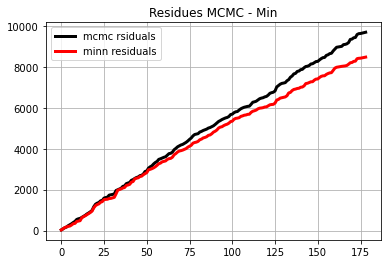

In [15]:
lkeys = [i for i in samp_dir.keys() if mc_resdir[i] != -1]

samps = [samp_dir[l] for l in lkeys]
mc_res = [mc_resdir[l] for l in lkeys]
min_res = [min_resdir[l] for l in lkeys]

plt.figure()
plt.plot(np.cumsum(mc_res), '-k', lineWidth = '3', label = 'mcmc rsiduals')
plt.plot(np.cumsum(min_res), '-r', lineWidth = '3', label = 'minn residuals')
plt.grid()
plt.title('Residues MCMC - Min')
plt.legend()
plt.show()

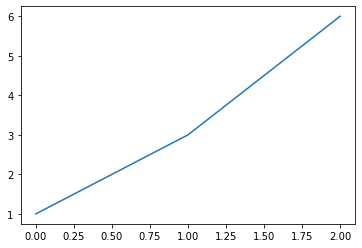

In [14]:
a = np.array([1,2,3])
b = np.cumsum(a)
plt.plot(b)

In [17]:
print(f'Average residual error for mcm - ', np.mean(mc_res))
print(f'Average residual error for minn - ', np.mean(min_res))


Average residual error for mcm -  54.14051912787155
Average residual error for minn -  47.34674305917724


In [18]:
print(f' Success before corrections-  {round(bc/len([i for i in mc_resdir.keys()])*100, 3)} %')
print(f' Success after corrections-  {round(len(lkeys)/len([i for i in mc_resdir.keys()])*100, 3)} %')

 Success before corrections-  31.25 %
 Success after corrections-  74.583 %


### Big Histograms of all the solutions

In [85]:
len([i for i in mc_resdir.keys()])

240

In [41]:
import matplotlib.mlab as mlab

def bigHist(sol_dir):
    SS, R, X, Y, CV = [], [], [], [], []
    T = ['SS', 'R', 'X', 'Y', 'CV'] 
    T2 = ['Swirling Strength', 'Radius', 'X-position', 'Y-position', 'Convective Velocity']
    for i in sol_dir.keys():
        if len(sol_dir[i]) == 1: continue 
        se = sol_dir[i]
        SS.append(se[0])
        R.append(se[1])
        X.append(se[2])
        Y.append(se[3])
        CV.append(se[4])
    ii = 0
    x_ = []
    y_ = []
    for i in [SS, R, X, Y, CV]:
        if len(SS) == 0: return
        plt.figure()
        a, b = np.histogram(i)
        b_  = [(b[i]+b[i+1])/2 for i in range(len(b)-1)]
        plt.plot(b_, a/np.max(a), '-y', lineWidth = 3, label = 'Trend line')
        x_.append(b_)
        y_.append(a/np.max(a))
        
        #p1 = mlab.normpdf( bins, mu, sigma)
        #l = plt.plot(b_, p1, 'r--', linewidth=2)
        
        a, b = np.histogram(i, bins = 50)
        b_  = [(b[i]+b[i+1])/2 for i in range(len(b)-1)]
        plt.plot(b_,a/np.max(a),'-g', lineWidth = 2 , label = 'True Data')
        #plt.plot(b_, p(b_), '-r', lineWidth = 3)
        plt.grid()
        #plt.xlabel(T[ii])
        #plt.ylabel('Normalized Count Magnitude')
        plt.legend()
        plt.title(T2[ii]+' Histogram', fontSize  = 15)
        ii+=1
    return x_, y_
        

In [34]:
len(min_soldir.keys())

240

In [35]:
min_soldir2 = {}
for i in lkeys:
    min_soldir2[i] = min_soldir[i]

In [36]:
min_soldir[1]

array([ 0.12466187,  0.0944165 ,  0.05059258, -0.00721278, -0.09643942])

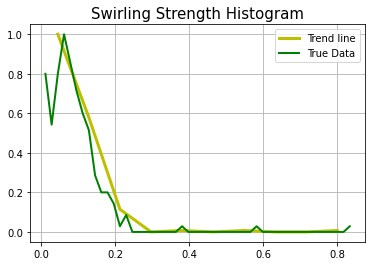

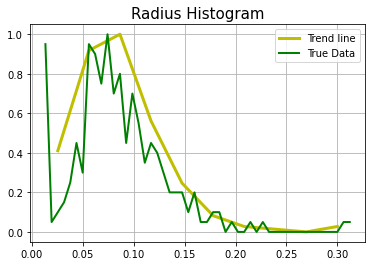

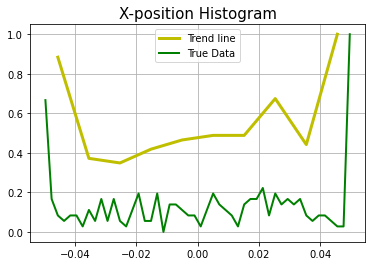

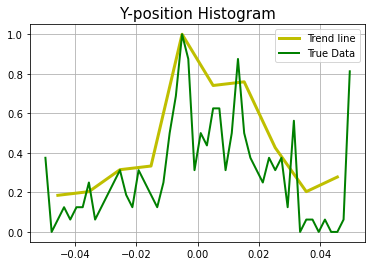

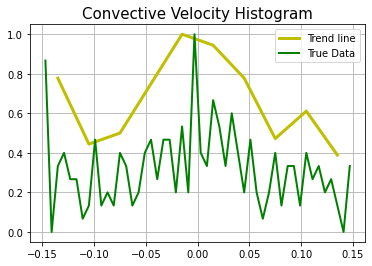

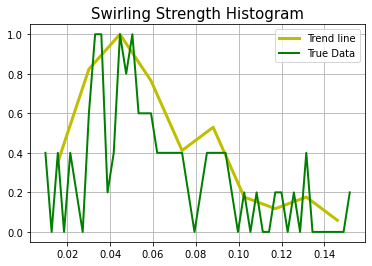

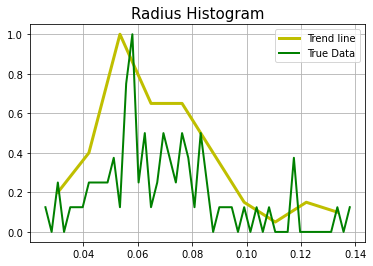

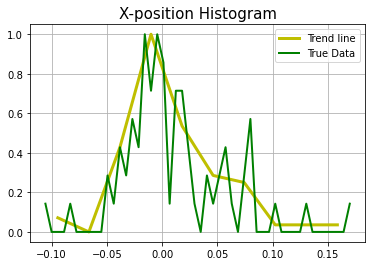

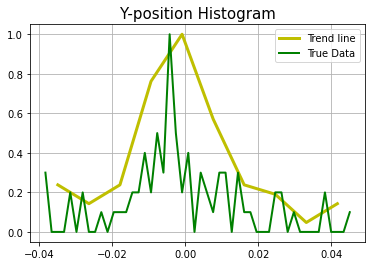

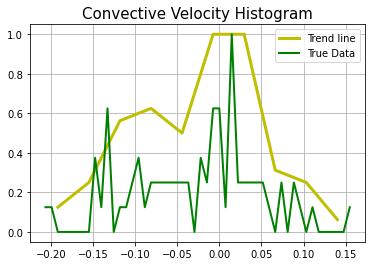

In [42]:
mnx, mny = bigHist(min_soldir)
mcx, mcy = bigHist(mc_soldir)


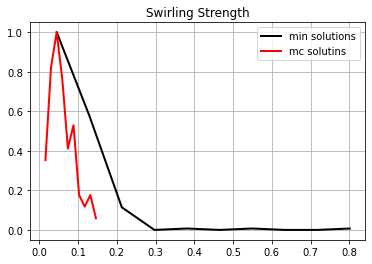

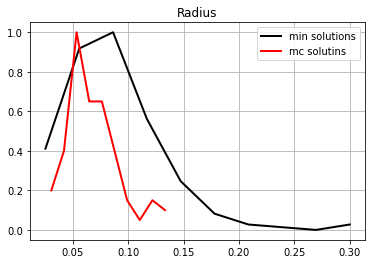

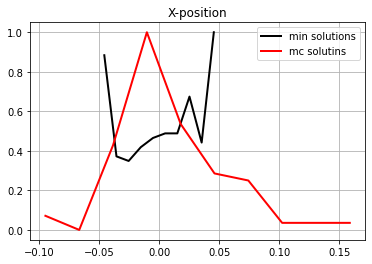

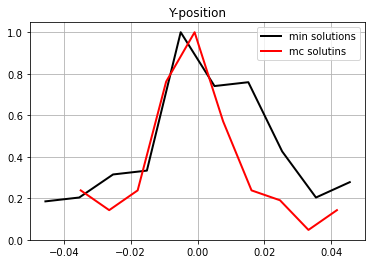

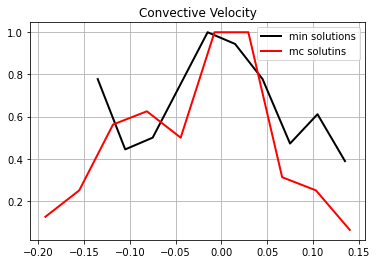

In [82]:
T2 = ['Swirling Strength', 'Radius', 'X-position', 'Y-position', 'Convective Velocity']

for i in range(5):
    plt.figure()
    plt.plot(mnx[i], mny[i], '-k', label = 'min solutions', lineWidth = 2)
    plt.plot(mcx[i], mcy[i], '-r', label = 'mc solutins', lineWidth = 2)
    plt.grid()
    plt.legend()
    plt.title(T2[i])
    plt.savefig(T2[i])
    
    

11 10
11 10


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

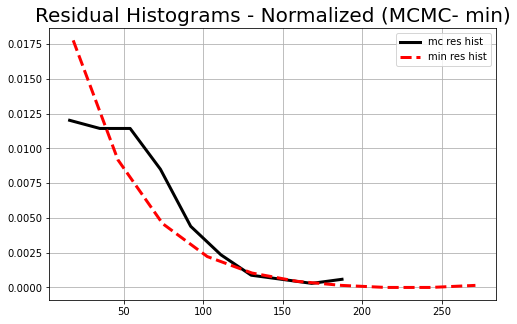

In [80]:
def resHist(resdir, verbose = True):
    res = []
    plt.figure()
    for i in resdir.keys():
        if resdir[i] != -1:
            res.append(resdir[i])
    a,b = np.histogram(res, density  = True)
    print(len(b),len(a))
    
    b_ = [(b[i]+b[i+1])/2 for i in range(len(b)-1)]
    if verbose:
        plt.plot(b_,a)
        plt.grid()
    return  b_, a

x1, y1 = resHist(mc_resdir, verbose  = False)
x2, y2 = resHist(min_resdir, verbose = False)

plt.figure(figsize = (8,5))
plt.plot(x1, y1,'-k', label = 'mc res hist', lineWidth = 3)
plt.plot(x2, y2, '--r', label  = 'min res hist', lineWidth = 3)
plt.grid()
plt.legend()
plt.title('Residual Histograms - Normalized (MCMC- min)', fontSize = 20)
plt.show()

In [83]:
len(lkeys)

179